In [1]:
# DataSet
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#import helper

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)




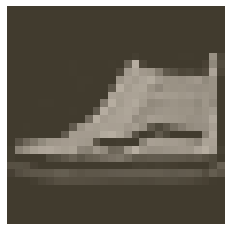

In [2]:
#test image

def imgshow(image, ax = None, title = None, normalize = True ):
    
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image+mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both', length = 0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax
image, label = next(iter(trainloader))

imgshow(image[0, :]);

In [3]:
# make the network 
"""
input layer: 28*28 = 764
hidden layer: 2개, 258, 128
output layer: 10개 (구별할 옷이 열 종류)
Adam Optimizer과 NLLLoss 활용
"""

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2) 
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x =  self.dropout(F.relu(self.fc1(x)))
        x =  self.dropout(F.relu(self.fc2(x))) 
        x =  self.dropout( F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x

    
        
        

In [4]:
# train a model
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 20

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #모델에서 훈련
        result = model(images)
        #오차 계산
        loss = criterion(result, labels)
        
        #초기화
        optimizer.zero_grad()
        
        #역전파
        loss.backward()
        
        #스텝
        optimizer.step()
        
        #오차값을 총 오차에 더함
        running_loss += loss.item()
        
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        
        

Training loss: 0.605611002648563
Training loss: 0.47905576167139674
Training loss: 0.4529489088477865
Training loss: 0.42949974853029127
Training loss: 0.41882602608343683
Training loss: 0.40455195198117544
Training loss: 0.40401644853831353
Training loss: 0.39350538460938916
Training loss: 0.38886519202958547
Training loss: 0.39023786928576193
Training loss: 0.38553167585688614
Training loss: 0.38124831462465625
Training loss: 0.37455077231057415
Training loss: 0.374395682049522
Training loss: 0.3704953845153485
Training loss: 0.3698672048016779
Training loss: 0.3642345941556034
Training loss: 0.36424201863533906
Training loss: 0.3533381641641863
Training loss: 0.3561749230268032


In [5]:
# Accuracy

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        #자동 미분을 꺼서 pytorch가 쓸 떼 없는 짓을 안한다. 
        with torch.no_grad():
            for images, labels in testloader:
                
                model.eval()
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                #로그 확률에 지수 적용
                ps = torch.exp(log_ps)
                
                #k번째로 큰 숫를 찾아낸다 / dim = 1 은 dimension을 의미한다.
                top_p, top_class = ps.topk(1, dim=1)
                
                #labels를 top_class와 똑같은 형태로 만든 다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)
                
                #equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print(
            "Epoch:{}/{}..".format(e+1, epochs),
            "Training Loss : {:.3f}..".format(running_loss / len(trainloader)),
            "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
            "Test Accuracy: {:3f}".format(accuracy/len(testloader))
             )
        
        
                


Epoch:1/20.. Training Loss : 0.354.. Test Loss: 0.281.. Test Accuracy: 0.894856
Epoch:2/20.. Training Loss : 0.354.. Test Loss: 0.268.. Test Accuracy: 0.901403
Epoch:3/20.. Training Loss : 0.356.. Test Loss: 0.267.. Test Accuracy: 0.901019
Epoch:4/20.. Training Loss : 0.348.. Test Loss: 0.270.. Test Accuracy: 0.899354
Epoch:5/20.. Training Loss : 0.353.. Test Loss: 0.263.. Test Accuracy: 0.904034
Epoch:6/20.. Training Loss : 0.348.. Test Loss: 0.275.. Test Accuracy: 0.897605
Epoch:7/20.. Training Loss : 0.348.. Test Loss: 0.252.. Test Accuracy: 0.907483
Epoch:8/20.. Training Loss : 0.343.. Test Loss: 0.266.. Test Accuracy: 0.900120
Epoch:9/20.. Training Loss : 0.348.. Test Loss: 0.284.. Test Accuracy: 0.895639
Epoch:10/20.. Training Loss : 0.339.. Test Loss: 0.257.. Test Accuracy: 0.905500
Epoch:11/20.. Training Loss : 0.334.. Test Loss: 0.271.. Test Accuracy: 0.901536
Epoch:12/20.. Training Loss : 0.337.. Test Loss: 0.257.. Test Accuracy: 0.905151
Epoch:13/20.. Training Loss : 0.343..

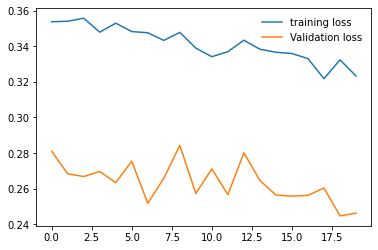

In [6]:
plt.plot(train_losses, label = "training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)